# Image classification

https://www.tensorflow.org/tutorials/images/classification

## Import Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Setup memory to fix critical issue
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
data_dir

WindowsPath('C:/Users/User/.keras/datasets/flower_photos')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


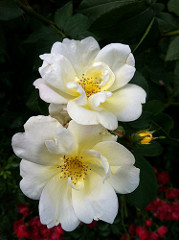

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

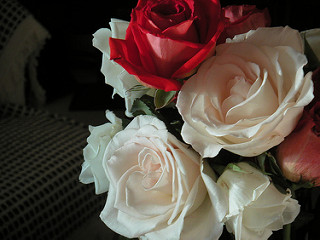

In [7]:
PIL.Image.open(str(roses[1]))

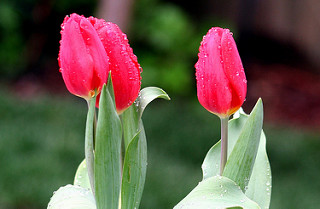

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

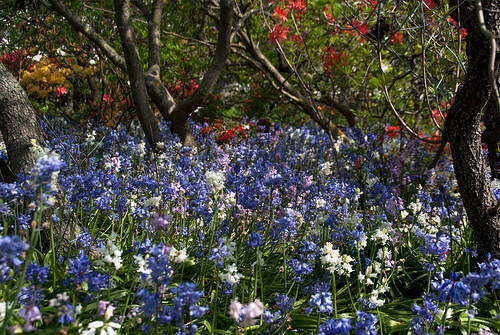

In [9]:
PIL.Image.open(str(tulips[1]))

## Preprocessing

### Create a dataset

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

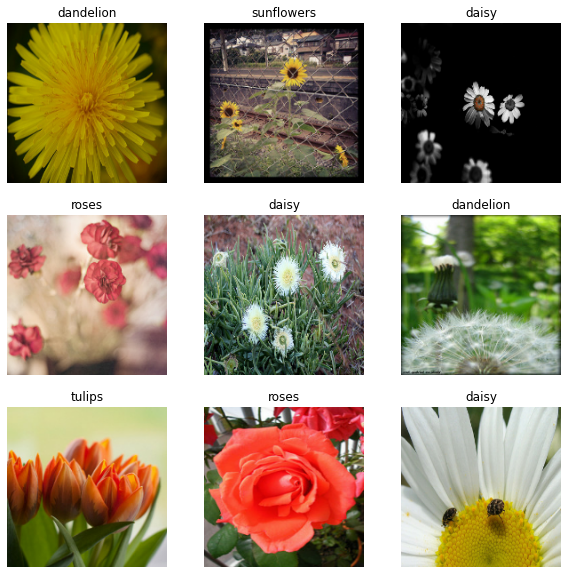

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


### Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.02886732 1.0


## Create the model

In [19]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Model compile and training

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
epochs=10

In [23]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 7s 51ms/step - loss: 1.7497 - accuracy: 0.3164 - val_loss: 1.0622 - val_accuracy: 0.5450
Epoch 2/10
92/92 [==============================] - 1s 12ms/step - loss: 1.0151 - accuracy: 0.5935 - val_loss: 0.9758 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 1s 12ms/step - loss: 0.8452 - accuracy: 0.6727 - val_loss: 0.9128 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 0.6272 - accuracy: 0.7669 - val_loss: 0.9336 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 1s 12ms/step - loss: 0.4485 - accuracy: 0.8532 - val_loss: 1.0528 - val_accuracy: 0.6431
Epoch 6/10
92/92 [==============================] - 1s 12ms/step - loss: 0.2613 - accuracy: 0.9130 - val_loss: 1.1621 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 1s 12ms/step - loss: 0.1484 - accuracy: 0.9547 - val_loss: 1.2365 - val_accuracy: 0.6308
Epoch 8/10
92

### Model evaluation

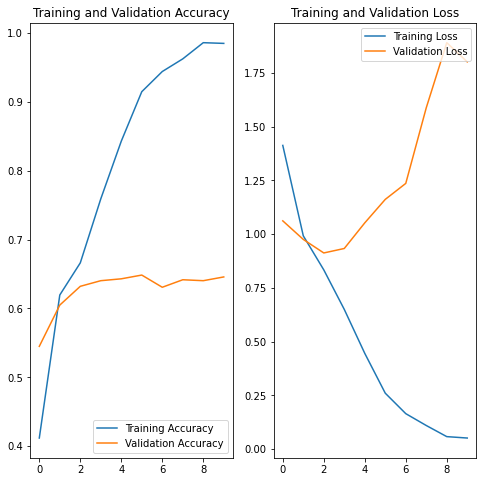

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

### Data augmentation

Generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.

In [26]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Visualize what a few augmented examples look like

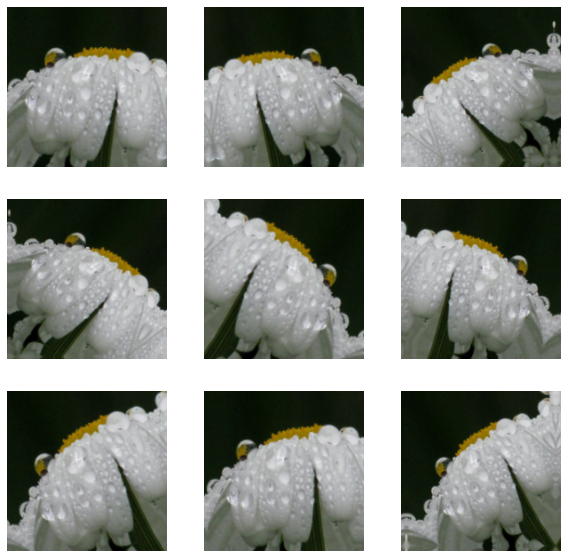

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Dropout

In [45]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Recompile and train the model

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 128)     3584      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 128)      

In [47]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 12s 93ms/step - loss: 1.5335 - accuracy: 0.3867 - val_loss: 1.0998 - val_accuracy: 0.5463
Epoch 2/50
92/92 [==============================] - 4s 45ms/step - loss: 1.0921 - accuracy: 0.5560 - val_loss: 1.0294 - val_accuracy: 0.5790
Epoch 3/50
92/92 [==============================] - 4s 45ms/step - loss: 1.0069 - accuracy: 0.6022 - val_loss: 1.0226 - val_accuracy: 0.5954
Epoch 4/50
92/92 [==============================] - 4s 45ms/step - loss: 0.9682 - accuracy: 0.6194 - val_loss: 0.9451 - val_accuracy: 0.6403
Epoch 5/50
92/92 [==============================] - 4s 45ms/step - loss: 0.8548 - accuracy: 0.6687 - val_loss: 0.8935 - val_accuracy: 0.6649
Epoch 6/50
92/92 [==============================] - 4s 45ms/step - loss: 0.7909 - accuracy: 0.6931 - val_loss: 0.8080 - val_accuracy: 0.6935
Epoch 7/50
92/92 [==============================] - 4s 45ms/step - loss: 0.7468 - accuracy: 0.7243 - val_loss: 0.7996 - val_accuracy: 0.6935
Epoch 8/50
9

### Visualize training results

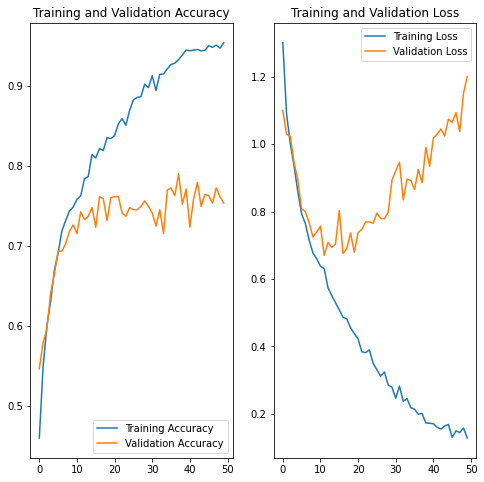

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [49]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 78.43 percent confidence.
